In [1]:
import numpy as np
import scipy
import pandas as pd
import requests
from os import makedirs, path, listdir, remove
from bs4 import BeautifulSoup, SoupStrainer
import zipfile as zpf
from shutil import rmtree
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist, cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import minimize
from matplotlib import cm
import re

import httplib2
import geopandas as gpd
from tqdm import tqdm
from graph_utils import *

In [2]:
region = "London"
start_date = "1996-01-01"
end_date = "2021-01-01"
data_folder = "/Users/michellewan/Library/CloudStorage/OneDrive-UniversityofCambridge/Documents/PhD/MEng_Kevin/Data and code"

In [30]:
# Load NO2 data

species = "NO2"
data_filename = f"LAQN_{species}_{start_date}_{end_date}.csv"
data = Dataset(path.join(data_folder, data_filename))
hourly_NO2 = data.df.set_index('date', inplace=False)
daily_NO2 = data.group('D')
print("Daily data shape:", daily_NO2.shape)

# Cut off before COVID
df_before_2020_NO2 = daily_NO2.loc[daily_NO2.index < '2020-01-01']

# Rename columns
df_before_2020_NO2 = df_before_2020_NO2.rename(columns={c: c+'_NO2' for c in df_before_2020_NO2.columns})

Daily data shape: (9133, 201)


In [31]:
# Load PM10 data

species = "PM10"
data_filename = f"LAQN_{species}_{start_date}_{end_date}.csv"
data = Dataset(path.join(data_folder, data_filename))
hourly_PM10 = data.df.set_index('date', inplace=False)
daily_PM10 = data.group('D')
print("Daily data shape:", daily_PM10.shape)

# Cut off before COVID
df_before_2020_PM10 = daily_PM10.loc[daily_PM10.index < '2020-01-01']

# Rename columns
df_before_2020_PM10 = df_before_2020_PM10.rename(columns={c: c+'_PM10' for c in df_before_2020_PM10.columns})


Daily data shape: (9133, 174)


In [32]:
# Concatenate NO2 and PM10 data
df_before_2020 = pd.concat([df_before_2020_NO2, df_before_2020_PM10], axis=1)
print("Daily data shape:", df_before_2020.shape)
print("Start date:", df_before_2020.index.min())
print("End date:", df_before_2020.index.max())

hourly_before_2020 = pd.concat([hourly_NO2, hourly_PM10], axis=1)
print("\nHourly data shape:", hourly_before_2020.shape)
print("Start date:", hourly_before_2020.index.min())
print("End date:", hourly_before_2020.index.max())

Daily data shape: (8766, 375)
Start date: 1996-01-01 00:00:00
End date: 2019-12-31 00:00:00

Hourly data shape: (219169, 375)
Start date: 1996-01-01 00:00:00
End date: 2021-01-01 00:00:00


## Daily data

In [6]:
# Find complete subset
complete_subset, column_names = get_complete_subset(df_before_2020, num_valid_values=500)
print("Complete subset shape:", complete_subset.shape)
print("Stations:", column_names)
print(complete_subset.index.min(), complete_subset.index.max())

Complete subset shape: (500, 33)
Stations: Index(['BG1_NO2', 'BY7_NO2', 'EA1_NO2', 'EN4_NO2', 'GB6_NO2', 'GR5_NO2',
       'HK4_NO2', 'HV3_NO2', 'LH2_NO2', 'HS4_NO2', 'IS2_NO2', 'KC2_NO2',
       'KC3_NO2', 'WE0_NO2', 'LB1_NO2', 'LW2_NO2', 'RB1_NO2', 'WA4_NO2',
       'WA2_NO2', 'MY1_NO2', 'BG2_PM10', 'BN2_PM10', 'BX4_PM10', 'CD3_PM10',
       'EA2_PM10', 'GB6_PM10', 'GR5_PM10', 'HR1_PM10', 'LH2_PM10', 'LW2_PM10',
       'SK1_PM10', 'ST4_PM10', 'MY1_PM10'],
      dtype='object')
2003-10-16 00:00:00 2005-02-26 00:00:00


In [7]:
# Try a separate test set
df_test = df_before_2020.loc[df_before_2020.index > complete_subset.index.max().strftime("%Y-%m-%d")]
complete_subset_test, column_names_test = get_complete_subset(df_test, num_valid_values=500)
# complete_subset_test = get_custom_subset(df_test, column_names, num_valid_values=500)
print("Complete test subset shape:", complete_subset_test.shape)
print("Stations:", column_names_test)
print(complete_subset_test.index.min(), complete_subset_test.index.max())
train_set = complete_subset
test_set = complete_subset_test

Complete test subset shape: (500, 31)
Stations: Index(['BN2_NO2', 'BN1_NO2', 'BX2_NO2', 'BX1_NO2', 'CT3_NO2', 'CR6_NO2',
       'CR4_NO2', 'EN3_NO2', 'GB6_NO2', 'HK4_NO2', 'HV1_NO2', 'HS7_NO2',
       'HS6_NO2', 'KC4_NO2', 'RB3_NO2', 'RB1_NO2', 'SK1_NO2', 'MY1_NO2',
       'BN2_PM10', 'BN1_PM10', 'BX2_PM10', 'BX4_PM10', 'BX1_PM10', 'CD1_PM10',
       'GR7_PM10', 'GR5_PM10', 'HR2_PM10', 'HR1_PM10', 'HI1_PM10', 'NM2_PM10',
       'ST4_PM10'],
      dtype='object')
2006-10-15 00:00:00 2008-02-26 00:00:00


In [8]:
# Normalise data between 0 and 1

def normalise_data(data):
    mins = data.min()
    maxs = data.max()
    normalized_data = (data - mins) / (maxs - mins)
    return normalized_data, mins, maxs

def denormalise_data(normalized_data, mins, maxs):
    return normalized_data * (maxs - mins) + mins

In [9]:
normalised_train, mins_train, maxs_train = normalise_data(train_set)
normalised_test, mins_test, maxs_test = normalise_data(test_set)
print("Normalised train data shape:", normalised_train.shape)
print("Normalised test data shape:", normalised_test.shape)
print("NaN values in training set:", normalised_train.isna().sum().sum())
print("NaN values in test set:", normalised_test.isna().sum().sum())

Normalised train data shape: (500, 33)
Normalised test data shape: (500, 31)
NaN values in training set: 0
NaN values in test set: 0


Training set:


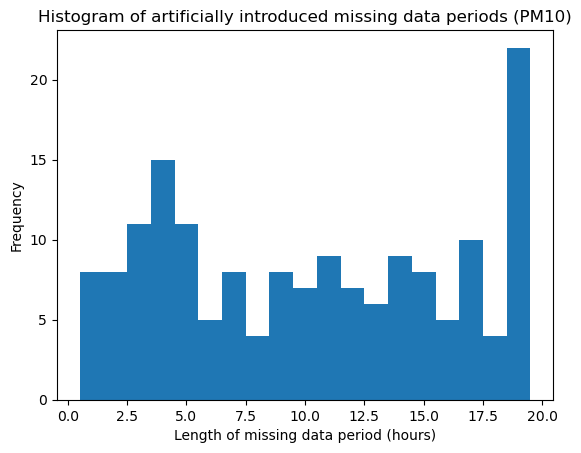

Test set:


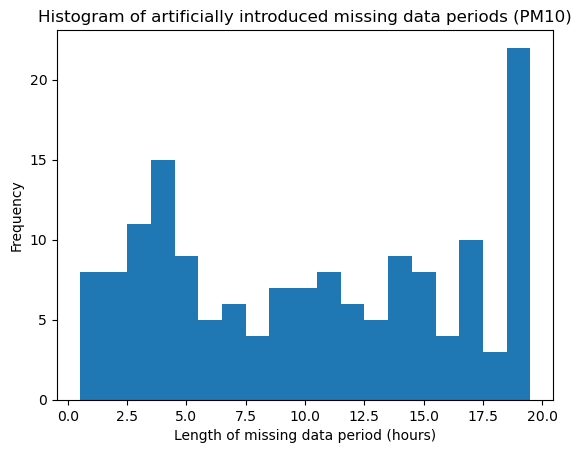

Proportion of missing data (training):  0.09121212121212122
Proportion of missing data (test):  0.09174193548387097


In [10]:
# INTRODUCE CONSECUTIVE GAPS

gap_proportion = 0.2 # Proportion of missing entries
max_period_length = 20 # Maximum length of missing data periods
species = 'PM10' # Name of the species for which gaps are introduced

print("Training set:")
gap_indices_train, true_values_train, subset_train = introduce_gaps(normalised_train, gap_proportion, max_period_length=max_period_length, species=species, plot_histogram=True)
print("Test set:")
gap_indices_test, true_values_test, subset_test = introduce_gaps(normalised_test, gap_proportion, max_period_length=max_period_length, species=species, plot_histogram=True)

print(f"Proportion of missing data (training): ", subset_train.isna().sum().sum()/(subset_train.size))
print(f"Proportion of missing data (test): ", subset_test.isna().sum().sum()/(subset_test.size))

In [11]:
# BASELINE METHODS

# ---------- Fill with mean of the station column

# Group by year and fill NaN values with the mean of each group
filled_data = subset_test.groupby(subset_test.index.year.rename('year')).apply(lambda group: group.fillna(group.mean()))

# Drop the additional "year" index created by groupby
filled_data.reset_index(level='year', drop=True, inplace=True)

# Extract only the estimated values for NaN indices
estimated_values = [filled_data.iloc[idx[0], idx[1]] for idx in gap_indices_test]

# Compute error
print(f"RMSE test set error after filling {species} with station annual means:", rmse_error(true_values_test, estimated_values))
print(f"SMAPE test set error after filling {species} with station annual means:", smape_error(true_values_test, estimated_values))

# ---------- Linear and polynomial interpolation

print("\nTest set errors after filling with polynomial interpolation:")

for order in range(1, 4):
    filled_data = subset_test.interpolate(method='polynomial', order=order, axis=0)

    # Check if there are still NaN values after interpolation
    remaining_gaps = filled_data.isna().sum().sum()

    if remaining_gaps > 0:
        print(f"Applying fill with annual mean concentrations for {remaining_gaps} remaining NaN values.")
        
        # Group by year and fill NaN values with the mean of each group
        filled_data = filled_data.groupby(filled_data.index.year.rename('year')).apply(lambda group: group.fillna(group.mean()))

        # Drop the additional "year" index created by groupby
        filled_data.reset_index(level='year', drop=True, inplace=True)

    # Extract only the estimated values for NaN indices
    estimated_values = [filled_data.iloc[idx[0], idx[1]] for idx in gap_indices_test]

    # Compute error for each method and print the results
    print(f"Order {order} RMSE: {rmse_error(true_values_test, estimated_values)}")
    print(f"Order {order} SMAPE: {smape_error(true_values_test, estimated_values)}")

    # # Set the figure size before creating the plot
    # plt.figure(figsize=(12, 6))

    # # Plot each column of the DataFrame
    # for column in filled_data.columns:
    #     plt.plot(filled_data.index, filled_data[column], label=column)

    # # Add labels and legend
    # plt.xlabel('Date')
    # plt.ylabel('NO2 concentration (ug/m3)')
    # plt.title(f'Filled data time series with polynomial interpolation order {order}')
    # plt.legend()
    # plt.show()

# print("Original data:")

# plt.figure(figsize=(12, 6))

# # Plot each column of the DataFrame
# for column in complete_subset.columns:
#     plt.plot(complete_subset.index, complete_subset[column], label=column)

# # Add labels and legend
# plt.xlabel('Date')
# plt.ylabel('NO2 concentration (ug/m3)')
# plt.title(f'Complete data time series')
# plt.legend()
# plt.show()


# print("Original data vs filled data:")
# olumn = column_names[0]

# plt.figure(figsize=(12, 6))

# plt.plot(test_set.index, test_set[column], label=f"{column} true values", alpha=0.75)
# plt.plot(filled_data.index, filled_data[column], label=f"{column} filled values", alpha=0.75)

# # Add labels and legend
# plt.xlabel('Date')
# plt.ylabel(f'{species} concentration (ug/m3)')
# plt.title(f'{column} original data vs filled data (polynomial interpolation order {order})')
# plt.legend()
# plt.show()


RMSE test set error after filling PM10 with station annual means: 0.1533615599995217
SMAPE test set error after filling PM10 with station annual means: 54.67702765381846

Test set errors after filling with polynomial interpolation:
Order 1 RMSE: 0.1476466367955507
Order 1 SMAPE: 48.66269201597555
Order 2 RMSE: 0.3225288459106764
Order 2 SMAPE: 100.4510701227133
Order 3 RMSE: 0.3302200142430512
Order 3 SMAPE: 102.30970664877412


/Users/michellewan/Repos/AQ-graph-prop/graph_utils.py:256: RuntimeWarning: invalid value encountered in double_scalars
  q = (w[i]/Y_i) * r
/Users/michellewan/Repos/AQ-graph-prop/graph_utils.py:260: RuntimeWarning: invalid value encountered in double_scalars
  r = (Y_i/Y_iplus) * prop_matrix.dot(r.T).T
/Users/michellewan/Repos/AQ-graph-prop/graph_utils.py:262: RuntimeWarning: invalid value encountered in double_scalars
  q = w[L]/w[L:].sum() * r


Minimum alpha error:  0.10609929095120901 Tuned alpha:  0.228
Minimum L-hops error:  0.10669144722580198 Tuned L-hops:  2
Minimum threshold error:  0.10500961368205909 Tuned threshold:  1.03
Training RMSE error: 0.10476928618638655
Training SMAPE error: 32.40953727944338
Test RMSE error: 0.0895581828674491
Test SMAPE error: 31.149642494832502


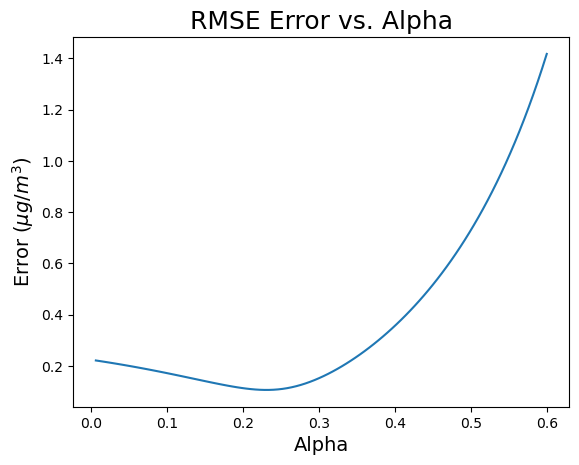

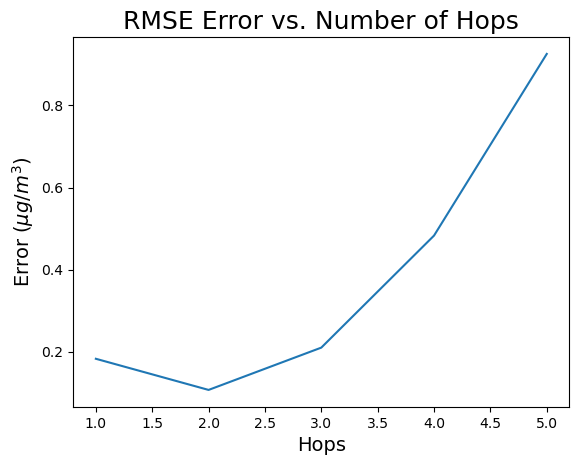

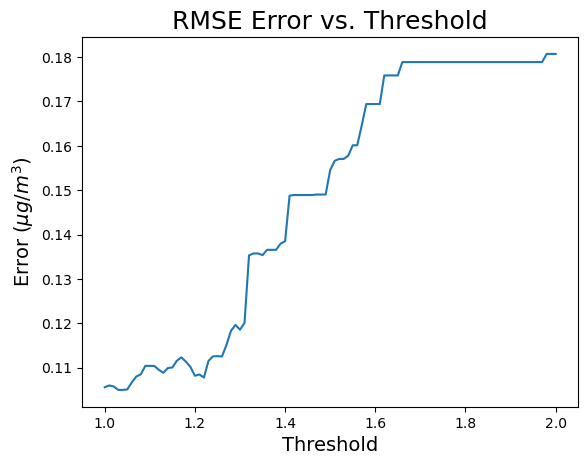

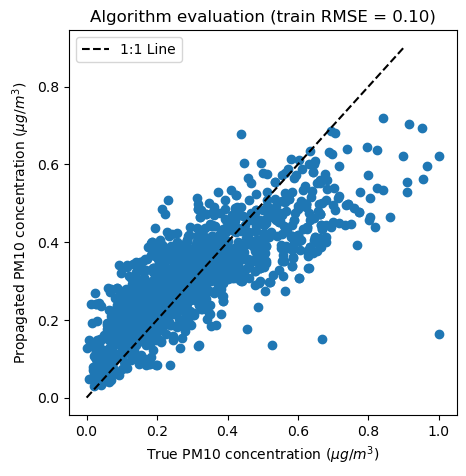

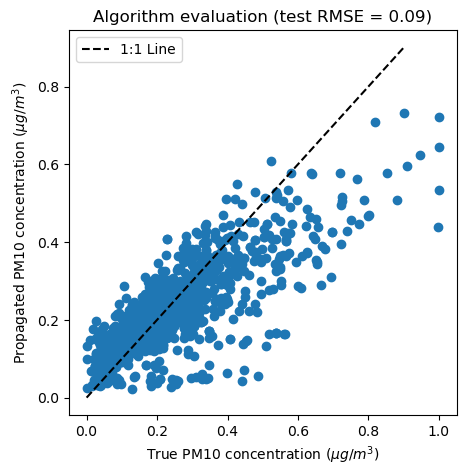

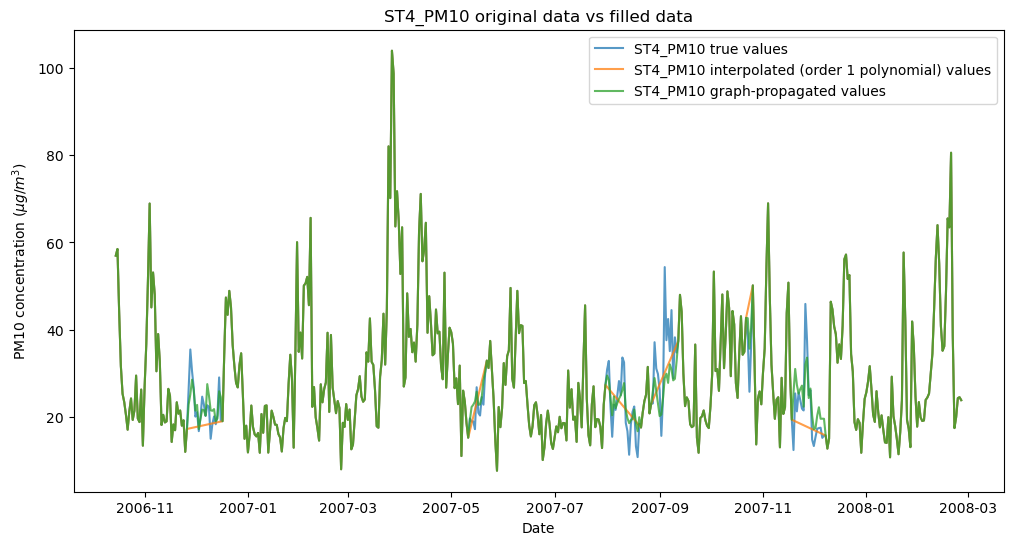

In [27]:
# GRAPH PROPAGATION

# ----------- Initialise training dataset with estimated interpolated values
order = 1
filled_data = subset_train.interpolate(method='polynomial', order=order, axis=0)

# Check if there are still NaN values after interpolation
remaining_gaps = filled_data.isna().sum().sum()

if remaining_gaps > 0:
    print(f"Applying fill with annual mean concentrations for {remaining_gaps} remaining NaN values.")
    
    # Group by year and fill NaN values with the mean of each group
    filled_data = filled_data.groupby(filled_data.index.year.rename('year')).apply(lambda group: group.fillna(group.mean()))

    # Drop the additional "year" index created by groupby
    filled_data.reset_index(level='year', drop=True, inplace=True)

euclidean = euclidean_AM(filled_data)
# print(euclidean)

# ----------- Tune hyperparameters

initialise_alpha = 0.2218
initialise_hop = 2
initialise_threshold = 1.06

# Plotting for different parameters

# Plotting for different alpha values
plt.figure(1)
alpha_err = []
alpha_range = np.linspace(0.0, 0.6, 101)
for alpha in alpha_range:
    # Compute error for each alpha value
    err = compute_error(alpha, initialise_threshold, initialise_hop, true_values_train, gap_indices_train, filled_data, euclidean)
    alpha_err.append(err)
plt.plot(alpha_range, alpha_err)
plt.title('RMSE Error vs. Alpha', fontsize=18)
plt.xlabel('Alpha', fontsize=14)
plt.ylabel('Error ($\mu g/m^3$)', fontsize=14)

# Plotting for different hop values
plt.figure(2)
hop_err = []
hop_range = np.arange(1, 6)
for L in hop_range:
    # Compute error for each number of hops
    err = compute_error(initialise_alpha, initialise_threshold, L, true_values_train, gap_indices_train, filled_data, euclidean)
    hop_err.append(err)
plt.plot(hop_range, hop_err)
plt.title('RMSE Error vs. Number of Hops', fontsize=18)
plt.xlabel('Hops', fontsize=14)
plt.ylabel('Error ($\mu g/m^3$)', fontsize=14)

# Plotting for different threshold values
plt.figure(3)
threshold_err = []
threshold_range = np.linspace(1.0, 2.0, 101)
for threshold in threshold_range:
    # Compute error for each threshold value
    err = compute_error(initialise_alpha, threshold, initialise_hop, true_values_train, gap_indices_train, filled_data, euclidean)
    threshold_err.append(err)
plt.plot(threshold_range, threshold_err)
plt.title('RMSE Error vs. Threshold', fontsize=18)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Error ($\mu g/m^3$)', fontsize=14)

# Assign tuned hyperparameters
alpha_err = np.nan_to_num(alpha_err, nan=np.inf)
hop_err = np.nan_to_num(hop_err, nan=np.inf)
threshold_err = np.nan_to_num(threshold_err, nan=np.inf)

tuned_alpha = alpha_range[np.argmin(alpha_err)]
tuned_hop = hop_range[np.argmin(hop_err)]
tuned_threshold = threshold_range[np.argmin(threshold_err)]

# Additional code to print minimum errors
print('Minimum alpha error: ', min(alpha_err), 'Tuned alpha: ', tuned_alpha)
print('Minimum L-hops error: ', min(hop_err), 'Tuned L-hops: ', tuned_hop)
print('Minimum threshold error: ', min(threshold_err), 'Tuned threshold: ', tuned_threshold)

tuned_alpha_daily, tuned_hop_daily, tuned_threshold_daily = tuned_alpha, tuned_hop, tuned_threshold

# ----------- Propagate values for training set

# Plot propagated training values against true training values

Z, A = compute_propagation_matrix(filled_data, euclidean, threshold=tuned_threshold, L=tuned_hop, alpha=tuned_alpha)
propagated_values = [Z[entry] for entry in gap_indices_train]

x = np.arange(filled_data.max().max(), step=0.1)
plt.figure(figsize=(5, 5))
plt.scatter(true_values_train, propagated_values)
# plt.scatter(denormalise_data(true_values_train, mins_train, maxs_train), denormalise_data(propagated_values, mins_train, maxs_train))
plt.plot(x, x, color='black', linestyle='--', label='1:1 Line')  # Adding a label for the 1:1 line
plt.title(f'Algorithm evaluation (train RMSE = {compute_error(tuned_alpha, tuned_threshold, tuned_hop, true_values_train, gap_indices_train, filled_data, euclidean):.2f})')
plt.xlabel(rf'True {species} concentration ($\mu g/m^3$)')  
plt.ylabel(rf'Propagated {species} concentration ($\mu g/m^3$)')  
plt.legend()  # Displaying the legend

print("Training RMSE error:", compute_error(tuned_alpha, tuned_threshold, tuned_hop, true_values_train, gap_indices_train, filled_data, euclidean))
print("Training SMAPE error:", compute_error(tuned_alpha, tuned_threshold, tuned_hop, true_values_train, gap_indices_train, filled_data, euclidean, error_type='smape'))

# ----------- Propagate values for test set

# Initialise test dataset with estimated interpolated values
order = 1
filled_data = subset_test.interpolate(method='polynomial', order=order, axis=0)

# Check if there are still NaN values after interpolation
remaining_gaps = filled_data.isna().sum().sum()

if remaining_gaps > 0:
    
    # Group by year and fill NaN values with the mean of each group
    filled_data = filled_data.groupby(filled_data.index.year.rename('year')).apply(lambda group: group.fillna(group.mean()))

    # Drop the additional "year" index created by groupby
    filled_data.reset_index(level='year', drop=True, inplace=True)

# Compute euclidean distance matrix
euclidean = euclidean_AM(filled_data)
# print(euclidean)

# Plot propagated test values against true test values

Z, A = compute_propagation_matrix(filled_data, euclidean, threshold=tuned_threshold, L=tuned_hop, alpha=tuned_alpha)
propagated_values = [Z[entry] for entry in gap_indices_test]


x = np.arange(filled_data.max().max(), step=0.1)
plt.figure(figsize=(5, 5))
# plt.scatter(denormalise_data(true_values_test, mins_test, maxs_test), denormalise_data(propagated_values, mins_test, maxs_test))
plt.scatter(true_values_test, propagated_values)
plt.plot(x, x, color='black', linestyle='--', label='1:1 Line')  # Adding a label for the 1:1 line
plt.title(f'Algorithm evaluation (test RMSE = {compute_error(tuned_alpha, tuned_threshold, tuned_hop, true_values_test, gap_indices_test, filled_data, euclidean):.2f})')
plt.xlabel(rf'True {species} concentration ($\mu g/m^3$)')  
plt.ylabel(rf'Propagated {species} concentration ($\mu g/m^3$)')  
plt.legend()  # Displaying the legend

print("Test RMSE error:", compute_error(tuned_alpha, tuned_threshold, tuned_hop, true_values_test, gap_indices_test, filled_data, euclidean))
print("Test SMAPE error:", compute_error(tuned_alpha, tuned_threshold, tuned_hop, true_values_test, gap_indices_test, filled_data, euclidean, error_type='smape'))

# ----------- Plot timeseries for interpolation methods

column = column_names_test[-1]

plt.figure(figsize=(12, 6))

plt.plot(test_set.index, test_set[column], label=f"{column} true values", alpha=0.75)
plt.plot(filled_data.index, denormalise_data(filled_data, mins_test, maxs_test)[column], label=f"{column} interpolated (order {order} polynomial) values", alpha=0.75)

# Replace graph-propagated values into the filled data from polynomial interpolation
for index, value in zip(gap_indices_test, propagated_values):
    filled_data.iloc[index[0], index[1]] = value

plt.plot(filled_data.index, denormalise_data(filled_data, mins_test, maxs_test)[column], label=f"{column} graph-propagated values", alpha=0.75)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel(f'{species} concentration ($\mu g/m^3$)')
plt.title(f'{column} original data vs filled data')
plt.legend()
plt.show()

## Hourly data

In [33]:
# Find complete subset
complete_subset, column_names = get_complete_subset(hourly_before_2020, num_valid_values=500)
print("Complete subset shape:", complete_subset.shape)
print("Stations:", column_names)
print(complete_subset.index.min(), complete_subset.index.max())

In [ ]:
# Try a separate test set
df_test = hourly_before_2020.loc[hourly_before_2020.index > complete_subset.index.max().strftime("%Y-%m-%d")]
complete_subset_test, column_names_test = get_complete_subset(df_test, num_valid_values=500)
# complete_subset_test = get_custom_subset(df_test, column_names, num_valid_values=500)
print("Complete test subset shape:", complete_subset_test.shape)
print("Stations:", column_names_test)
print(complete_subset_test.index.min(), complete_subset_test.index.max())
train_set = complete_subset
test_set = complete_subset_test

Complete test subset shape: (500, 31)
Stations: Index(['BN2_NO2', 'BN1_NO2', 'BX2_NO2', 'BX1_NO2', 'CT3_NO2', 'CR6_NO2',
       'CR4_NO2', 'EN3_NO2', 'GB6_NO2', 'HK4_NO2', 'HV1_NO2', 'HS7_NO2',
       'HS6_NO2', 'KC4_NO2', 'RB3_NO2', 'RB1_NO2', 'SK1_NO2', 'MY1_NO2',
       'BN2_PM10', 'BN1_PM10', 'BX2_PM10', 'BX4_PM10', 'BX1_PM10', 'CD1_PM10',
       'GR7_PM10', 'GR5_PM10', 'HR2_PM10', 'HR1_PM10', 'HI1_PM10', 'NM2_PM10',
       'ST4_PM10'],
      dtype='object')
2006-10-15 00:00:00 2008-02-26 00:00:00


In [ ]:
normalised_train, mins_train, maxs_train = normalise_data(train_set)
normalised_test, mins_test, maxs_test = normalise_data(test_set)
print("Normalised train data shape:", normalised_train.shape)
print("Normalised test data shape:", normalised_test.shape)
print("NaN values in training set:", normalised_train.isna().sum().sum())
print("NaN values in test set:", normalised_test.isna().sum().sum())

Normalised train data shape: (500, 33)
Normalised test data shape: (500, 31)
NaN values in training set: 0
NaN values in test set: 0


Training set:


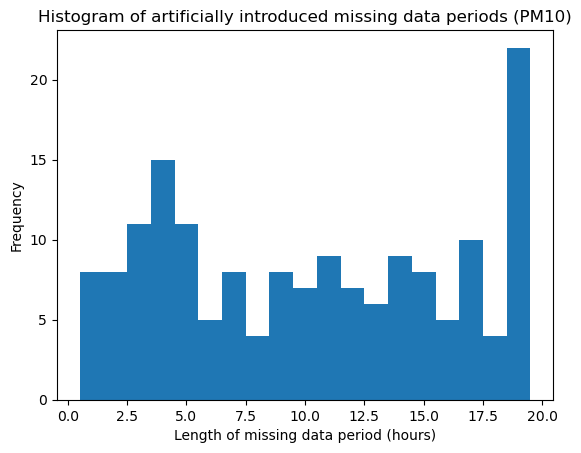

Test set:


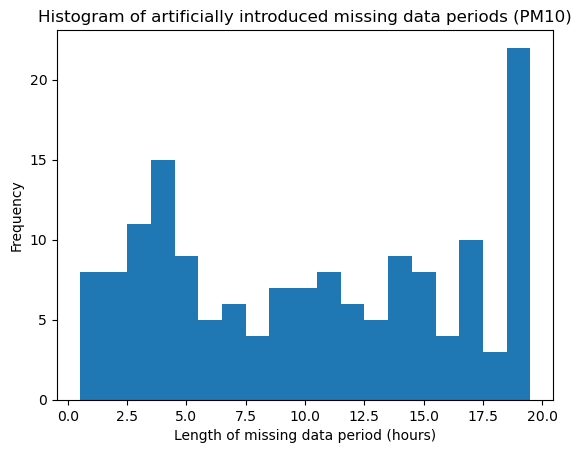

Proportion of missing data (training):  0.09121212121212122
Proportion of missing data (test):  0.09174193548387097


In [ ]:
# INTRODUCE CONSECUTIVE GAPS

gap_proportion = 0.2 # Proportion of missing entries
max_period_length = 20 # Maximum length of missing data periods
species = 'PM10' # Name of the species for which gaps are introduced

print("Training set:")
gap_indices_train, true_values_train, subset_train = introduce_gaps(normalised_train, gap_proportion, max_period_length=max_period_length, species=species, plot_histogram=True)
print("Test set:")
gap_indices_test, true_values_test, subset_test = introduce_gaps(normalised_test, gap_proportion, max_period_length=max_period_length, species=species, plot_histogram=True)

print(f"Proportion of missing data (training): ", subset_train.isna().sum().sum()/(subset_train.size))
print(f"Proportion of missing data (test): ", subset_test.isna().sum().sum()/(subset_test.size))

In [ ]:
# BASELINE METHODS

# ---------- Fill with mean of the station column

# Group by year and fill NaN values with the mean of each group
filled_data = subset_test.groupby(subset_test.index.year.rename('year')).apply(lambda group: group.fillna(group.mean()))

# Drop the additional "year" index created by groupby
filled_data.reset_index(level='year', drop=True, inplace=True)

# Extract only the estimated values for NaN indices
estimated_values = [filled_data.iloc[idx[0], idx[1]] for idx in gap_indices_test]

# Compute error
print(f"RMSE test set error after filling {species} with station annual means:", rmse_error(true_values_test, estimated_values))
print(f"SMAPE test set error after filling {species} with station annual means:", smape_error(true_values_test, estimated_values))

# ---------- Linear and polynomial interpolation

print("\nTest set errors after filling with polynomial interpolation:")

for order in range(1, 4):
    filled_data = subset_test.interpolate(method='polynomial', order=order, axis=0)

    # Check if there are still NaN values after interpolation
    remaining_gaps = filled_data.isna().sum().sum()

    if remaining_gaps > 0:
        print(f"Applying fill with annual mean concentrations for {remaining_gaps} remaining NaN values.")
        
        # Group by year and fill NaN values with the mean of each group
        filled_data = filled_data.groupby(filled_data.index.year.rename('year')).apply(lambda group: group.fillna(group.mean()))

        # Drop the additional "year" index created by groupby
        filled_data.reset_index(level='year', drop=True, inplace=True)

    # Extract only the estimated values for NaN indices
    estimated_values = [filled_data.iloc[idx[0], idx[1]] for idx in gap_indices_test]

    # Compute error for each method and print the results
    print(f"Order {order} RMSE: {rmse_error(true_values_test, estimated_values)}")
    print(f"Order {order} SMAPE: {smape_error(true_values_test, estimated_values)}")

    # # Set the figure size before creating the plot
    # plt.figure(figsize=(12, 6))

    # # Plot each column of the DataFrame
    # for column in filled_data.columns:
    #     plt.plot(filled_data.index, filled_data[column], label=column)

    # # Add labels and legend
    # plt.xlabel('Date')
    # plt.ylabel('NO2 concentration (ug/m3)')
    # plt.title(f'Filled data time series with polynomial interpolation order {order}')
    # plt.legend()
    # plt.show()

# print("Original data:")

# plt.figure(figsize=(12, 6))

# # Plot each column of the DataFrame
# for column in complete_subset.columns:
#     plt.plot(complete_subset.index, complete_subset[column], label=column)

# # Add labels and legend
# plt.xlabel('Date')
# plt.ylabel('NO2 concentration (ug/m3)')
# plt.title(f'Complete data time series')
# plt.legend()
# plt.show()


# print("Original data vs filled data:")
# olumn = column_names[0]

# plt.figure(figsize=(12, 6))

# plt.plot(test_set.index, test_set[column], label=f"{column} true values", alpha=0.75)
# plt.plot(filled_data.index, filled_data[column], label=f"{column} filled values", alpha=0.75)

# # Add labels and legend
# plt.xlabel('Date')
# plt.ylabel(f'{species} concentration (ug/m3)')
# plt.title(f'{column} original data vs filled data (polynomial interpolation order {order})')
# plt.legend()
# plt.show()


RMSE test set error after filling PM10 with station annual means: 0.1533615599995217
SMAPE test set error after filling PM10 with station annual means: 54.67702765381846

Test set errors after filling with polynomial interpolation:
Order 1 RMSE: 0.1476466367955507
Order 1 SMAPE: 48.66269201597555
Order 2 RMSE: 0.3225288459106764
Order 2 SMAPE: 100.4510701227133
Order 3 RMSE: 0.3302200142430512
Order 3 SMAPE: 102.30970664877412


/Users/michellewan/Repos/AQ-graph-prop/graph_utils.py:256: RuntimeWarning: invalid value encountered in double_scalars
  q = (w[i]/Y_i) * r
/Users/michellewan/Repos/AQ-graph-prop/graph_utils.py:260: RuntimeWarning: invalid value encountered in double_scalars
  r = (Y_i/Y_iplus) * prop_matrix.dot(r.T).T
/Users/michellewan/Repos/AQ-graph-prop/graph_utils.py:262: RuntimeWarning: invalid value encountered in double_scalars
  q = w[L]/w[L:].sum() * r


Minimum alpha error:  0.10609929095120901 Tuned alpha:  0.228
Minimum L-hops error:  0.10669144722580198 Tuned L-hops:  2
Minimum threshold error:  0.10500961368205909 Tuned threshold:  1.03
Training RMSE error: 0.10476928618638655
Training SMAPE error: 32.40953727944338
Test RMSE error: 0.0895581828674491
Test SMAPE error: 31.149642494832502


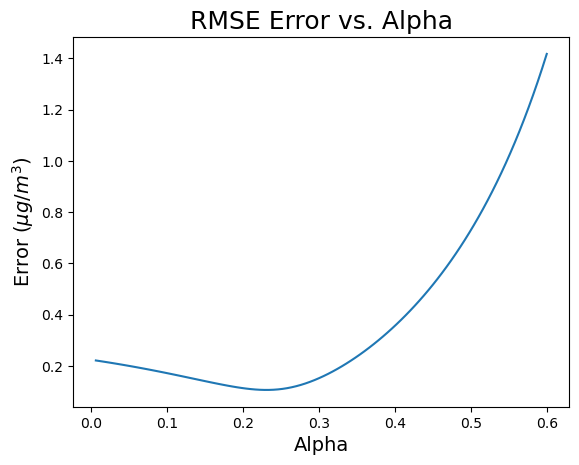

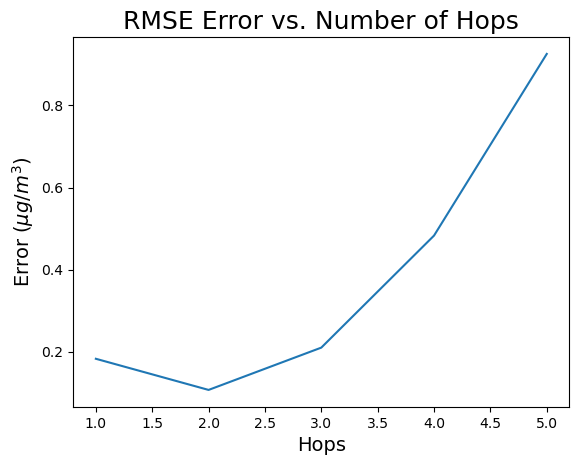

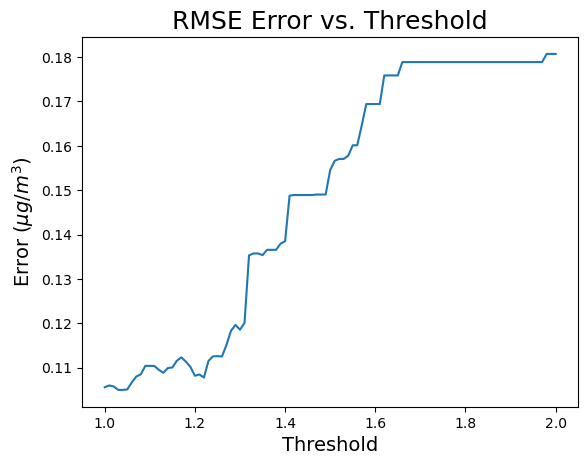

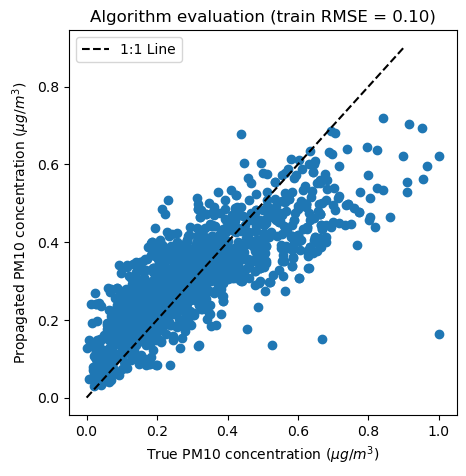

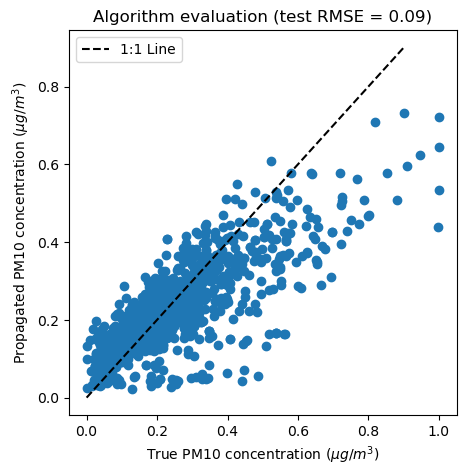

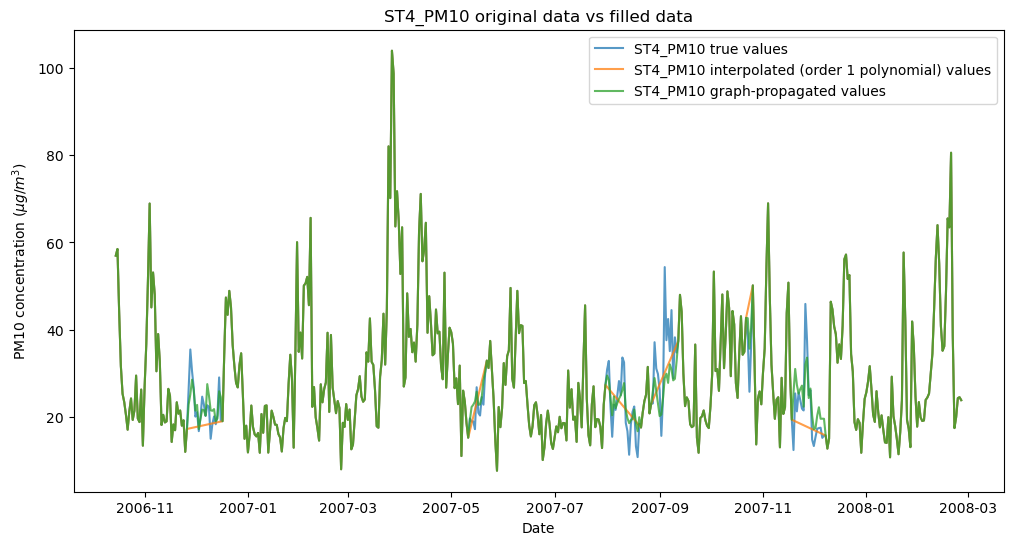

In [ ]:
# GRAPH PROPAGATION

# ----------- Initialise training dataset with estimated interpolated values
order = 1
filled_data = subset_train.interpolate(method='polynomial', order=order, axis=0)

# Check if there are still NaN values after interpolation
remaining_gaps = filled_data.isna().sum().sum()

if remaining_gaps > 0:
    print(f"Applying fill with annual mean concentrations for {remaining_gaps} remaining NaN values.")
    
    # Group by year and fill NaN values with the mean of each group
    filled_data = filled_data.groupby(filled_data.index.year.rename('year')).apply(lambda group: group.fillna(group.mean()))

    # Drop the additional "year" index created by groupby
    filled_data.reset_index(level='year', drop=True, inplace=True)

euclidean = euclidean_AM(filled_data)
# print(euclidean)

# ----------- Tune hyperparameters

initialise_alpha = 0.2218
initialise_hop = 2
initialise_threshold = 1.06

# Plotting for different parameters

# Plotting for different alpha values
plt.figure(1)
alpha_err = []
alpha_range = np.linspace(0.0, 0.6, 101)
for alpha in alpha_range:
    # Compute error for each alpha value
    err = compute_error(alpha, initialise_threshold, initialise_hop, true_values_train, gap_indices_train, filled_data, euclidean)
    alpha_err.append(err)
plt.plot(alpha_range, alpha_err)
plt.title('RMSE Error vs. Alpha', fontsize=18)
plt.xlabel('Alpha', fontsize=14)
plt.ylabel('Error ($\mu g/m^3$)', fontsize=14)

# Plotting for different hop values
plt.figure(2)
hop_err = []
hop_range = np.arange(1, 6)
for L in hop_range:
    # Compute error for each number of hops
    err = compute_error(initialise_alpha, initialise_threshold, L, true_values_train, gap_indices_train, filled_data, euclidean)
    hop_err.append(err)
plt.plot(hop_range, hop_err)
plt.title('RMSE Error vs. Number of Hops', fontsize=18)
plt.xlabel('Hops', fontsize=14)
plt.ylabel('Error ($\mu g/m^3$)', fontsize=14)

# Plotting for different threshold values
plt.figure(3)
threshold_err = []
threshold_range = np.linspace(1.0, 2.0, 101)
for threshold in threshold_range:
    # Compute error for each threshold value
    err = compute_error(initialise_alpha, threshold, initialise_hop, true_values_train, gap_indices_train, filled_data, euclidean)
    threshold_err.append(err)
plt.plot(threshold_range, threshold_err)
plt.title('RMSE Error vs. Threshold', fontsize=18)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Error ($\mu g/m^3$)', fontsize=14)

# Assign tuned hyperparameters
alpha_err = np.nan_to_num(alpha_err, nan=np.inf)
hop_err = np.nan_to_num(hop_err, nan=np.inf)
threshold_err = np.nan_to_num(threshold_err, nan=np.inf)

tuned_alpha = alpha_range[np.argmin(alpha_err)]
tuned_hop = hop_range[np.argmin(hop_err)]
tuned_threshold = threshold_range[np.argmin(threshold_err)]

# Additional code to print minimum errors
print('Minimum alpha error: ', min(alpha_err), 'Tuned alpha: ', tuned_alpha)
print('Minimum L-hops error: ', min(hop_err), 'Tuned L-hops: ', tuned_hop)
print('Minimum threshold error: ', min(threshold_err), 'Tuned threshold: ', tuned_threshold)

tuned_alpha_daily, tuned_hop_daily, tuned_threshold_daily = tuned_alpha, tuned_hop, tuned_threshold

# ----------- Propagate values for training set

# Plot propagated training values against true training values

Z, A = compute_propagation_matrix(filled_data, euclidean, threshold=tuned_threshold, L=tuned_hop, alpha=tuned_alpha)
propagated_values = [Z[entry] for entry in gap_indices_train]

x = np.arange(filled_data.max().max(), step=0.1)
plt.figure(figsize=(5, 5))
plt.scatter(true_values_train, propagated_values)
# plt.scatter(denormalise_data(true_values_train, mins_train, maxs_train), denormalise_data(propagated_values, mins_train, maxs_train))
plt.plot(x, x, color='black', linestyle='--', label='1:1 Line')  # Adding a label for the 1:1 line
plt.title(f'Algorithm evaluation (train RMSE = {compute_error(tuned_alpha, tuned_threshold, tuned_hop, true_values_train, gap_indices_train, filled_data, euclidean):.2f})')
plt.xlabel(rf'True {species} concentration ($\mu g/m^3$)')  
plt.ylabel(rf'Propagated {species} concentration ($\mu g/m^3$)')  
plt.legend()  # Displaying the legend

print("Training RMSE error:", compute_error(tuned_alpha, tuned_threshold, tuned_hop, true_values_train, gap_indices_train, filled_data, euclidean))
print("Training SMAPE error:", compute_error(tuned_alpha, tuned_threshold, tuned_hop, true_values_train, gap_indices_train, filled_data, euclidean, error_type='smape'))

# ----------- Propagate values for test set

# Initialise test dataset with estimated interpolated values
order = 1
filled_data = subset_test.interpolate(method='polynomial', order=order, axis=0)

# Check if there are still NaN values after interpolation
remaining_gaps = filled_data.isna().sum().sum()

if remaining_gaps > 0:
    
    # Group by year and fill NaN values with the mean of each group
    filled_data = filled_data.groupby(filled_data.index.year.rename('year')).apply(lambda group: group.fillna(group.mean()))

    # Drop the additional "year" index created by groupby
    filled_data.reset_index(level='year', drop=True, inplace=True)

# Compute euclidean distance matrix
euclidean = euclidean_AM(filled_data)
# print(euclidean)

# Plot propagated test values against true test values

Z, A = compute_propagation_matrix(filled_data, euclidean, threshold=tuned_threshold, L=tuned_hop, alpha=tuned_alpha)
propagated_values = [Z[entry] for entry in gap_indices_test]


x = np.arange(filled_data.max().max(), step=0.1)
plt.figure(figsize=(5, 5))
# plt.scatter(denormalise_data(true_values_test, mins_test, maxs_test), denormalise_data(propagated_values, mins_test, maxs_test))
plt.scatter(true_values_test, propagated_values)
plt.plot(x, x, color='black', linestyle='--', label='1:1 Line')  # Adding a label for the 1:1 line
plt.title(f'Algorithm evaluation (test RMSE = {compute_error(tuned_alpha, tuned_threshold, tuned_hop, true_values_test, gap_indices_test, filled_data, euclidean):.2f})')
plt.xlabel(rf'True {species} concentration ($\mu g/m^3$)')  
plt.ylabel(rf'Propagated {species} concentration ($\mu g/m^3$)')  
plt.legend()  # Displaying the legend

print("Test RMSE error:", compute_error(tuned_alpha, tuned_threshold, tuned_hop, true_values_test, gap_indices_test, filled_data, euclidean))
print("Test SMAPE error:", compute_error(tuned_alpha, tuned_threshold, tuned_hop, true_values_test, gap_indices_test, filled_data, euclidean, error_type='smape'))

# ----------- Plot timeseries for interpolation methods

column = column_names_test[-1]

plt.figure(figsize=(12, 6))

plt.plot(test_set.index, test_set[column], label=f"{column} true values", alpha=0.75)
plt.plot(filled_data.index, denormalise_data(filled_data, mins_test, maxs_test)[column], label=f"{column} interpolated (order {order} polynomial) values", alpha=0.75)

# Replace graph-propagated values into the filled data from polynomial interpolation
for index, value in zip(gap_indices_test, propagated_values):
    filled_data.iloc[index[0], index[1]] = value

plt.plot(filled_data.index, denormalise_data(filled_data, mins_test, maxs_test)[column], label=f"{column} graph-propagated values", alpha=0.75)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel(f'{species} concentration ($\mu g/m^3$)')
plt.title(f'{column} original data vs filled data')
plt.legend()
plt.show()